In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import dates
import astropy.units as u
import astropy.constants as const
from astropy.time import Time
from astroquery.jplhorizons import Horizons
from astropy.coordinates import EarthLocation
from scipy import interpolate

In [2]:
d = np.loadtxt("ch2.dat")
tobs = Time(d[:, 0], format="mjd", scale="utc")
fobs = d[:, 1]*u.Hz

In [3]:
dwingeloo = EarthLocation(lat="52d48m43.27", lon="6d23m46.21", height="25m")
dwingeloo_jpl = {'lat': dwingeloo.lat.deg, 'lon': dwingeloo.lon.deg, 'elevation': dwingeloo.height.to(u.m).value}

In [4]:
madrid = EarthLocation(lat="40d25m45", lon="-4d14m57", height="720m")
madrid_jpl = {'lat': madrid.lat.deg, 'lon': madrid.lon.deg, 'elevation': madrid.height.to(u.m).value}

In [5]:
tmod = Time("2019-09-06T18:10") + np.linspace(0, 140, 100, endpoint=False)*u.min

In [6]:
ephem_ch2_rx = Horizons(id='Chandrayaan-2 (LANDER spacecraft)', location=dwingeloo_jpl,
                    epochs=list(tmod.jd), id_type='majorbody').ephemerides()

In [7]:
ephem_ch2_tx = Horizons(id='Chandrayaan-2 (LANDER spacecraft)', location=madrid_jpl,
                    epochs=list(tmod.jd), id_type='majorbody').ephemerides()

In [8]:
ephem_moon_rx = Horizons(id='301', location=dwingeloo_jpl,
                      epochs=list(tmod.jd), id_type='majorbody').ephemerides()

In [9]:
ephem_moon_tx = Horizons(id='301', location=madrid_jpl,
                      epochs=list(tmod.jd), id_type='majorbody').ephemerides()

In [10]:
fcen = 2284.538*u.MHz

In [11]:
fch2 = (1.0-ephem_ch2_rx["delta_rate"].to(u.m/u.s)/const.c)*fcen

In [12]:
fmoon = (1.0-ephem_moon_rx["delta_rate"].to(u.m/u.s)/const.c)*fcen

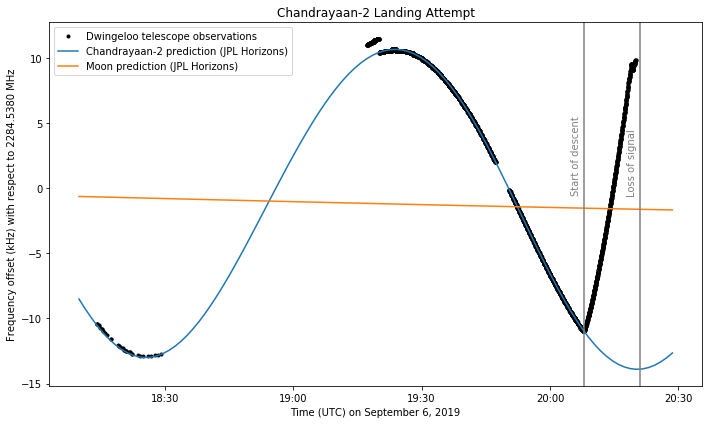

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(tobs.datetime, (fobs-fcen).to(u.kHz), "k.", label="Dwingeloo telescope observations")
ax.plot(tmod.datetime, (fch2-fcen).to(u.kHz), label="Chandrayaan-2 prediction (JPL Horizons)")
ax.plot(tmod.datetime, (fmoon-fcen).to(u.kHz), label="Moon prediction (JPL Horizons)")
ax.xaxis.set_major_formatter(dates.DateFormatter('%H:%M'))
ax.set_xlabel("Time (UTC) on September 6, 2019")
ax.set_ylabel("Frequency offset (kHz) with respect to %.4f MHz" % (fcen.to(u.MHz).value))
ax.set_title("Chandrayaan-2 Landing Attempt")
ax.axvline(Time("2019-09-06T20:08:00", format="isot", scale="utc").datetime, color="gray")
ax.text(Time("2019-09-06T20:05:00", format="isot", scale="utc").datetime, 5, "Start of descent",
        color="gray", rotation="vertical")
ax.axvline(Time("2019-09-06T20:21:00", format="isot", scale="utc").datetime, color="gray")
ax.text(Time("2019-09-06T20:18:00", format="isot", scale="utc").datetime, 4, "Loss of signal",
        color="gray", rotation="vertical")
ax.legend()
plt.tight_layout()
plt.savefig("doppler_curve.png", bbox_inches="tight")

**Update September 9, 2019**

At the Dwingeloo Telescope, we receive a frequency $f_\mathrm{dt}=(1-\frac{v_\mathrm{dt}}{c})f_\mathrm{sc}$. Here, $f_\mathrm{dt}$ is the observed frequency at the Dwingeloo Telescope, and $v_\mathrm{dt}$ is the line-of-sight velocity between the spacecraft and the Dwingeloo Telescope. $c$ is the speed of light. The spacecraft itself transmits at a frequency $f_\mathrm{sc}$.

The spacecraft transmitter is locked to the Madrid DSN ground station, such that $f_\mathrm{sc}=(1-\frac{v_\mathrm{dsn}}{c})f_\mathrm{dsn}$, where $v_\mathrm{dsn}$ is the line-of-sight velocity between the spacecraft and the Madrid DSN ground station. Hence, the observed frequency at the Dwingeloo Telescope is $f_\mathrm{dt}=(1-\frac{v_\mathrm{dt}}{c})(1-\frac{v_\mathrm{dsn}}{c})f_\mathrm{dsn}$.

However, in the case of the Chandrayaan-2 Vikram landing, the Madrid DSN ground station was compensating for the Doppler effect based on the orbit prediction, such that $f_\mathrm{dsn}^\mathrm{pred}=(1+\frac{v_\mathrm{dsn}^\mathrm{pred}}{c})f_0$. As a result, the observed frequency at the Dwingeloo telescope is $f_\mathrm{dt}=(1-\frac{v_\mathrm{dt}}{c})(1-\frac{v_\mathrm{dsn}}{c})(1+\frac{v_\mathrm{dsn}^\mathrm{pred}}{c})f_0$. Expanding this equation gives $\frac{v}{c}$ terms, as well as terms scaling as $\frac{v^2}{c^2}$ and $\frac{v^3}{c^3}$, which can be neglected as $v$ is much smaller than $c$. Hence, we obtain $f_\mathrm{dt}=(1-\frac{v_\mathrm{dt}}{c}-\frac{v_\mathrm{dsn}}{c}+\frac{v_\mathrm{dsn}^\mathrm{pred}}{c})f_0$.

Prior to the descent burn of Vikram, the Doppler compensation corrected for the predicted orbit, which was very close to the actual orbit. Hence, $v_\mathrm{dsn}=v_\mathrm{dsn}^\mathrm{pred}$, cancelling the two terms. As a result the observed frequency by the Dwingeloo Telescope was $f_\mathrm{dt}=(1-\frac{v_\mathrm{dt}}{c})f_0$, which is identical to the one-way Doppler effect. By comparing the observed Doppler curve of the orbit prior to the descent burn with the JPL Horizons predictions for $v_\mathrm{dt}$ we can obtain $f_0=2284.5380$ MHz.

We can rewrite the equation to $v_\mathrm{dt}+v_\mathrm{dsn}=v_\mathrm{dsn}^\mathrm{pred}-(\frac{f_\mathrm{dt}}{f_0}-1)c$. This equation is also valid the descent burn, though we will have to assume $v_\mathrm{dsn}^\mathrm{pred}$. If we assume that the Madrid DSN ground station kept on correcting the Doppler effect of the orbit prior to the descent burn, we can compute the sum of line-of-sight velocities to the Dwingeloo Telescope and the Madrid DSN ground station $v_\mathrm{dt}+v_\mathrm{dsn}$. Since the Dwingeloo Telescope and the Madrid DSN ground station are relatively close together, we can assume that $v_\mathrm{dt}\sim v_\mathrm{dsn}=v$, and hence $v=\frac{1}{2}(v_\mathrm{dsn}^\mathrm{pred}-(\frac{f_\mathrm{dt}}{f_0}-1)c)$.

In [14]:
v_dsn_pred = interpolate.interp1d(tmod.mjd, ephem_ch2_tx["delta_rate"].to(u.m/u.s).value)

In [15]:
vlos = 0.5*(v_dsn_pred(tobs.mjd)*u.m/u.s-(fobs/fcen-1.0)*const.c)

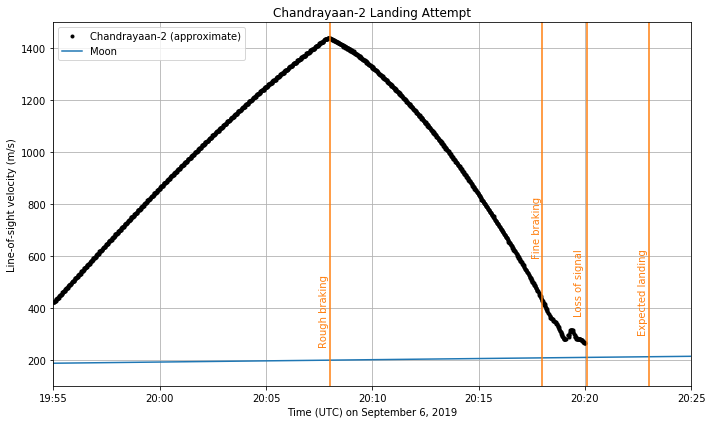

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(tobs.datetime, vlos, "k.", label="Chandrayaan-2 (approximate)")
ax.plot(tmod.datetime, ephem_moon_rx["delta_rate"].to(u.m/u.s), label="Moon")
ax.xaxis.set_major_formatter(dates.DateFormatter('%H:%M'))
ax.set_xlabel("Time (UTC) on September 6, 2019")
ax.set_ylabel("Line-of-sight velocity (m/s)")
ax.set_title("Chandrayaan-2 Landing Attempt")
ax.axvline(Time("2019-09-06T20:08:00", format="isot", scale="utc").datetime, color="C1")
ax.text(Time("2019-09-06T20:07:30", format="isot", scale="utc").datetime, 500, "Rough braking",
        color="C1", rotation="vertical")
ax.axvline(Time("2019-09-06T20:18:00", format="isot", scale="utc").datetime, color="C1")
ax.text(Time("2019-09-06T20:17:30", format="isot", scale="utc").datetime, 800, "Fine braking",
        color="C1", rotation="vertical")
ax.axvline(Time("2019-09-06T20:20:05", format="isot", scale="utc").datetime, color="C1")
ax.text(Time("2019-09-06T20:19:30", format="isot", scale="utc").datetime, 600, "Loss of signal",
        color="C1", rotation="vertical")
ax.axvline(Time("2019-09-06T20:23:00", format="isot", scale="utc").datetime, color="C1")
ax.text(Time("2019-09-06T20:22:30", format="isot", scale="utc").datetime, 600, "Expected landing",
        color="C1", rotation="vertical")
ax.set_xlim(Time("2019-09-06T19:55:00", format="isot", scale="utc").datetime, 
            Time("2019-09-06T20:25:00", format="isot", scale="utc").datetime)
ax.set_ylim(100, 1500)
ax.legend()
ax.grid()
plt.tight_layout()
plt.savefig("line-of-sight_velocity.png", bbox_inches="tight")

In [17]:
v_moon = interpolate.interp1d(tmod.mjd, ephem_moon_rx["delta_rate"].to(u.m/u.s).value)

In [18]:
print("Line-of-sight velocity at loss of contact: ", vlos[-1]-v_moon(tobs[-1].mjd)*u.m/u.s)

Line-of-sight velocity at loss of contact:  53.6846655153075 m / s
